# LDA with SciKit Learn

DS 5001 Text as Data

**Purpose**: In this notebook we create a topic model from our corpus  using SciKit Learn's library.

# Set Up

## Imports

In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

In [83]:
pd.set_option('display.max_colwidth', None)

## Config

In [15]:
import configparser
config = configparser.ConfigParser()
config.read('../../../env.ini')
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [16]:
data_prefix = 'austen-melville'
colors = "YlGnBu"

In [17]:
ngram_range = (1, 2)
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 9

In [41]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [42]:
BAG = CHAP

## Pragmas

In [43]:
import warnings
warnings.filterwarnings('ignore')

# Prepare Data

## Convert `TOKENS` back to `DOCS`

Scikit Learn wants an F1 style corpus. We create onefrom our annotated TOKEN table, keeping only regular nouns.

In [44]:
# TOKENS = pd.read_csv(f'{output_dir}/{data_prefix}-TOKEN2.csv')

In [45]:
TOKENS = pd.read_csv(f'{output_dir}/{data_prefix}-CORPUS.csv').set_index(OHCO)

In [46]:
TOKENS.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                             
105     1       1        0        0               ('Sir', 'NNP')  NNP   
                                  1            ('Walter', 'NNP')  NNP   
                                  2           ('Elliot,', 'NNP')  NNP   
                                  3                 ('of', 'IN')   IN   
                                  4          ('Kellynch', 'NNP')  NNP   

                                            token_str  term_str pos_group  
book_id chap_id para_num sent_num token_num                                
105     1       1        0        0               Sir       sir        NN  
                                  1            Walter    walter        NN  
                                  2           Elliot,    elliot        NN  
                                  3                of        of        IN  
                                  4          Kellynch  kellynch        NN

In [47]:
BAG

['book_id', 'chap_id']

## Filter for Nouns

In [51]:
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(map(str,x)))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [53]:
DOCS.head()

doc_str
book_id chap_id                                                   
105     1        man who amusement book occupation hour consola...
        2        civil lawyer hold views anybody else hint refe...
        3        i leave morning newspaper juncture favour peac...
        4        curate appearances brother commander consequen...
        5        morning walk way opportunity them meeting part...

## Create Vector Space

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [54]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [55]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

In [56]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [57]:
DTM

abbey  abhorrence  abilities  aboard  abode  abroad  absence  \
book_id chap_id                                                                 
105     1            0           0          0       0      0       0        0   
        2            0           0          1       0      1       0        0   
        3            0           0          0       0      0       1        0   
        4            0           0          0       0      0       0        0   
        5            0           0          0       0      0       0        2   
...                ...         ...        ...     ...    ...     ...      ...   
34970   110          0           0          0       0      0       0        0   
        111          0           0          0       0      0       0        1   
        112          0           0          0       0      0       0        0   
        113          0           0          0       0      0       0        0   
        114          0           0          0       0      0       0        0   

                 absent  absolute  absurdity  ...  yesterday  yillah  yonder  \
book_id chap_id                               ...                              
105     1             0         0          0  ...          0       0       0   
        2             0         0          0  ...          0       0       0   
        3             0         0          0  ...          0       0       0   
        4             0         0          0  ...          0       0       0   
        5             0         0          0  ...          1       0       0   
...                 ...       ...        ...  ...        ...     ...     ...   
34970   110           0         0          0  ...          0       0       2   
        111           0         0          0  ...          0       0       0   
        112           0         0          0  ...          0       0       0   
        113           0         0          0  ...          0       0       0   
        114           0         0          0  ...          0       0       0   

                 yoomy  yore  youll  young  youth  youths  zeal  
book_id chap_id                                                  
105     1            0     0      0      0      3       0     0  
        2            0     0      0      0      0       0     0  
        3            0     0      0      0      2       0     1  
        4            0     0      0      1      3       0     0  
        5            0     0      0      1      0       0     0  
...                ...   ...    ...    ...    ...     ...   ...  
34970   110          0     0      0      0      0       0     0  
        111          0     0      0      0      0       0     0  
        112          0     0      0      0      0       0     0  
        113          0     0      0      0      0       0     0  
        114          0     0      0      0      0       0     0  

[1173 rows x 4000 columns]

In [58]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [59]:
VOCAB

,doc_count
term_str,
abbey,13
abhorrence,32
abilities,34
aboard,33
abode,44
...,...
youll,15
young,25
youth,145


In [60]:
DOCS.term_count.describe()

count     1173.000000
mean       263.986360
std        388.375574
min          0.000000
25%        127.000000
50%        222.000000
75%        343.000000
max      12058.000000
Name: term_count, dtype: float64

# Generate Model

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [64]:
# LDA?

In [65]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

## Topic Names

In [66]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

## THETA

In [67]:
lda_model = lda_engine.fit_transform(count_model)

In [70]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [71]:
THETA.sample(10).T.style.background_gradient(cmap=colors, axis=None)

## PHI

In [72]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [73]:
PHI.T.sample(10).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
novels,2.402535,0.025000,0.025000,1.812597,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,7.785244,0.025000,4.099624,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
patience,0.025000,2.141819,8.502648,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.058150,23.261156,0.456188,0.025000,6.437700,0.025000,2.464533,0.025000,0.025000,26.011236,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,5.843082,0.025000,0.025000,0.025000,0.025000,3.073488,0.025000,0.025000,0.025000
bound,0.025000,0.025000,0.025000,8.017845,0.025000,3.539516,3.800111,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.310277,0.025000,3.260881,8.288930,0.025000,5.103485,3.842545,0.025000,0.025000,1.702953,0.025000,1.868945,8.761850,4.036920,0.025000,0.025000,20.347532,35.682909,0.025000,0.025000,0.025000,0.025000,0.025000,1.810301,0.025000
ruin,0.025000,0.025000,0.025000,0.025000,3.135645,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.797916,0.025000,0.025000,1.025000,0.025000,0.025000,13.198181,0.025000,0.941870,0.025000,11.998279,0.025000,0.025000,0.025000,0.025000,0.025000,1.080587,1.064977,0.025000,2.982545,0.025000,0.025000,0.025000
task,0.025000,6.770134,0.025000,0.025000,0.025000,0.025000,0.025000,1.599332,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.102772,5.256071,1.157629,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,10.246040,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,9.043021,0.025000,0.025000,0.025000
uneasiness,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.907068,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,33.351402,0.816530,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
drinking,0.025000,3.945574,0.025000,0.025000,0.025000,6.895792,2.244671,0.025000,0.025000,4.698429,0.436958,0.025000,0.025000,0.025000,0.025000,3.917819,0.025000,0.025000,5.438925,0.025000,1.025000,0.025000,1.000800,4.101647,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,6.569384,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
rising,2.220832,1.247946,3.898151,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,1.025000,0.025000,0.025000,0.025000,7.156868,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,9.471004,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.155199
numbers,3.756168,0.025000,0.025000,0.025000,0.025000,16.260221,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,9.875661,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,4.796502,0.025000,0.025000,0.025000,0.025000,7.455898,0.025000,0.025000,0.025000,4.829108,0.025000,2.201442,0.025000


In [75]:
# PHI.T / PHI.T.sum()

# Inspect Results

## Create `TOPICS` and get Top Terms per Topic

In [82]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')

In [84]:
TOPICS.style

,top_terms
topic_id,
T00,room house door time day night bed hour moment
T01,lord man things men gods soul time thing heart
T02,sir thou thee boy man brother way oh hand
T03,round man child hand ha time wine head image
T04,jacket philosophy friend man boots tho freind alas pair
T05,valley natives island time islanders house fruit trees ground
T06,consul place emigrants steerage doctor rest ship day water
T07,ye man leg thou hand aye eyes look arm
T08,feet man head crown tail blade coat woman vault


In [ ]:
# TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)

In [ ]:
# print(TOPICS.label.values)

## Sort Topics by Doc Weight

In [90]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [91]:
TOPICS.sort_values('doc_weight_sum', ascending=False).style.background_gradient(cmap=colors)

,top_terms,doc_weight_sum,term_freq
topic_id,,,
T23,time letter sister feelings heart mind family man mother,163.569493,0.152309
T15,time room thing man day oh friend way moment,140.340735,0.151227
T32,man men deck ship time sailors sea mate captain,94.888590,0.087131
T31,sea water air ship wind boat day land sight,76.190798,0.063084
T01,lord man things men gods soul time thing heart,72.288680,0.048015
T05,valley natives island time islanders house fruit trees ground,52.151496,0.053893
T18,man friend sort stranger way time gentleman case money,45.478509,0.045462
T36,whale whales boat ship head boats sea fish time,45.423579,0.040541
T00,room house door time day night bed hour moment,40.273350,0.040483


In [105]:
cols = TOPICS.columns[1:].to_list()
r = TOPICS[cols].corr().iloc[1,1]

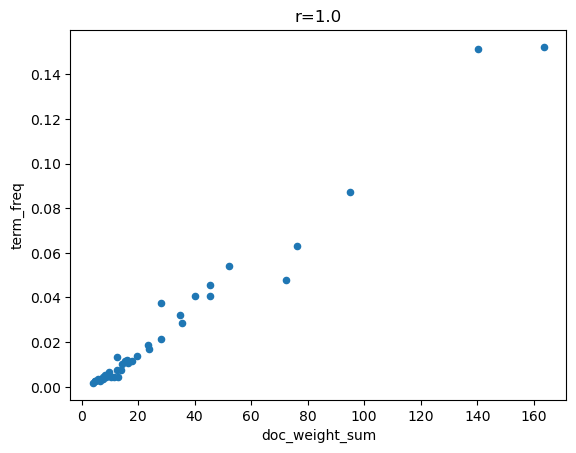

In [106]:
TOPICS.plot.scatter(*cols, title=f"r={r}");

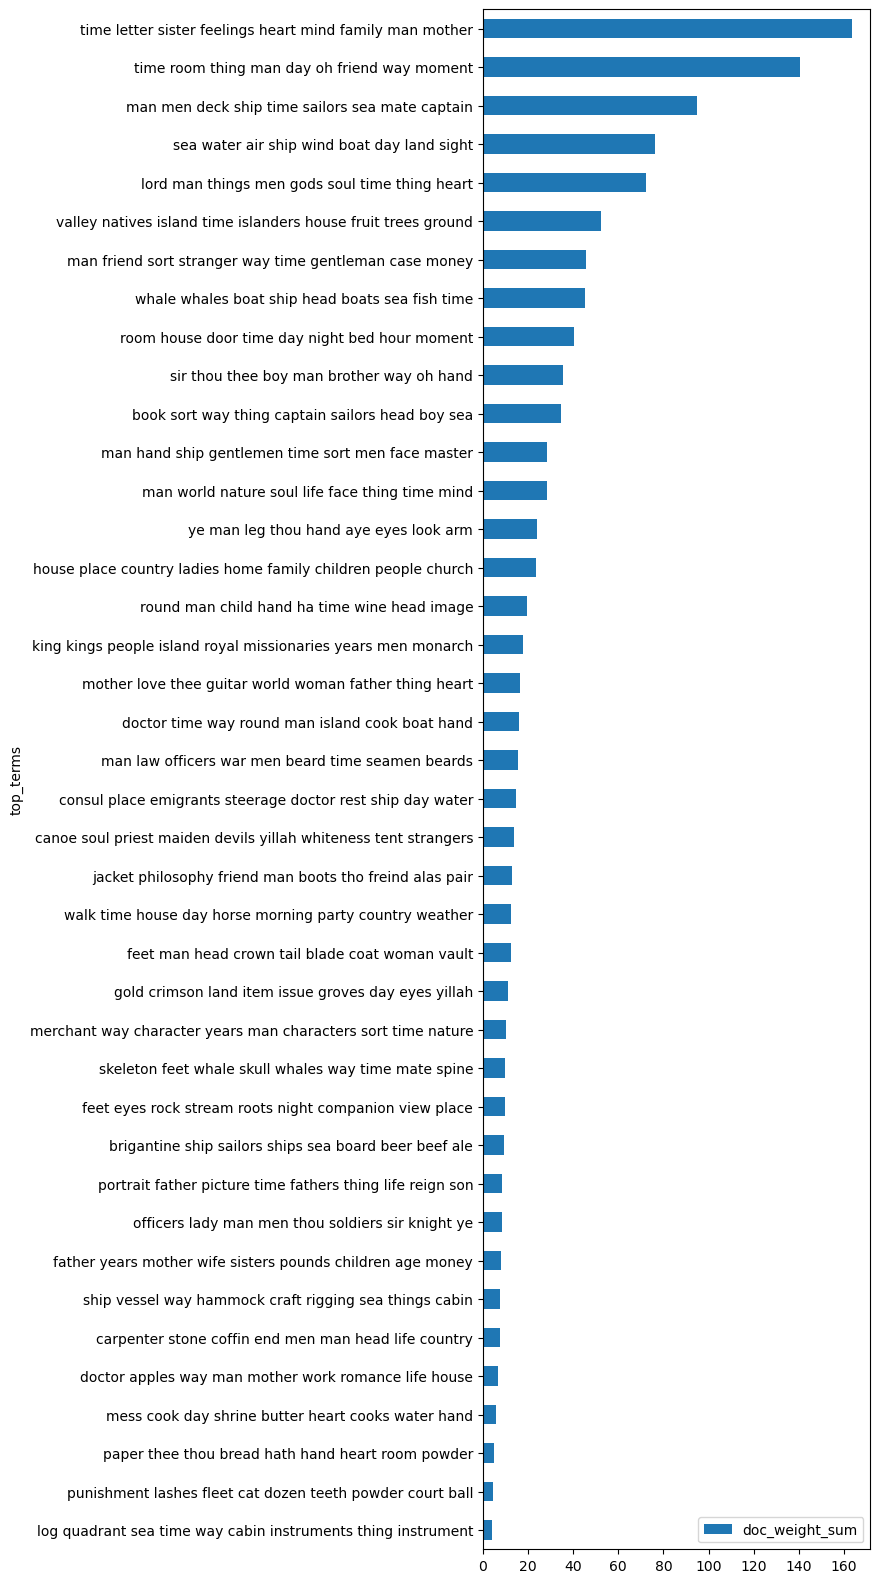

In [107]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='top_terms', figsize=(5, n_topics/2));

In [109]:
# TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='top_terms', figsize=(5, n_topics/2));

# Explore Topics by Author

Use the LIB table to get author info.

In [111]:
# LIB = pd.read_csv(f'{output_dir}/{data_prefix}-LIB_FIXED.csv').set_index('book_id')

In [113]:
LIB = pd.read_csv(f'{output_dir}/{data_prefix}-LIB.csv').set_index('book_id')

In [115]:
# LIB

Create a short label for each author for display purposes.

In [116]:
LIB['author_key'] = LIB.author.str.split(', ').str[0].str.lower()

Add mean topic weight for each topic by author.

In [117]:
AUTHORS = sorted(LIB.author_key.value_counts().index.to_list())

In [118]:
TOPICS[AUTHORS] = THETA.join(LIB, on='book_id').groupby('author_key')[TNAMES].mean().T

In [120]:
TOPICS

,top_terms,doc_weight_sum,term_freq,austen,melville
topic_id,,,,,
T00,room house door time day night bed hour moment,40.273350,0.040483,0.035586,0.033835
T01,lord man things men gods soul time thing heart,72.288680,0.048015,0.001284,0.085649
T02,sir thou thee boy man brother way oh hand,35.694933,0.028381,0.002101,0.041708
T03,round man child hand ha time wine head image,19.503756,0.013573,0.001035,0.022834
T04,jacket philosophy friend man boots tho freind alas pair,12.717129,0.004400,0.013486,0.009789
T05,valley natives island time islanders house fruit trees ground,52.151496,0.053893,0.001484,0.061568
T06,consul place emigrants steerage doctor rest ship day water,14.455065,0.010243,0.000180,0.017157
T07,ye man leg thou hand aye eyes look arm,23.945168,0.016742,0.000768,0.028234
T08,feet man head crown tail blade coat woman vault,12.528364,0.007346,0.000784,0.014620


View by topic order.

In [121]:
TOPICS[AUTHORS + ['top_terms']].style.background_gradient(cmap=colors, axis=None)

,austen,melville,top_terms
topic_id,,,
T00,0.035586,0.033835,room house door time day night bed hour moment
T01,0.001284,0.085649,lord man things men gods soul time thing heart
T02,0.002101,0.041708,sir thou thee boy man brother way oh hand
T03,0.001035,0.022834,round man child hand ha time wine head image
T04,0.013486,0.009789,jacket philosophy friend man boots tho freind alas pair
T05,0.001484,0.061568,valley natives island time islanders house fruit trees ground
T06,0.000180,0.017157,consul place emigrants steerage doctor rest ship day water
T07,0.000768,0.028234,ye man leg thou hand aye eyes look arm
T08,0.000784,0.014620,feet man head crown tail blade coat woman vault


In [122]:
TOPICS[AUTHORS + ['top_terms']].sort_values('austen', ascending=False)\
    .style.background_gradient(cmap=colors, axis=None)

,austen,melville,top_terms
topic_id,,,
T23,0.445419,0.017640,time letter sister feelings heart mind family man mother
T15,0.382449,0.015021,time room thing man day oh friend way moment
T09,0.037978,0.012823,house place country ladies home family children people church
T00,0.035586,0.033835,room house door time day night bed hour moment
T25,0.024627,0.005245,walk time house day horse morning party country weather
T04,0.013486,0.009789,jacket philosophy friend man boots tho freind alas pair
T10,0.011876,0.004988,father years mother wife sisters pounds children age money
T11,0.004529,0.005967,doctor apples way man mother work romance life house
T13,0.004276,0.039716,book sort way thing captain sailors head boy sea


In [123]:
TOPICS[AUTHORS + ['top_terms']].sort_values('melville', ascending=False)\
    .style.background_gradient(cmap=colors, axis=None)

,austen,melville,top_terms
topic_id,,,
T32,0.001400,0.112540,man men deck ship time sailors sea mate captain
T31,0.001111,0.090369,sea water air ship wind boat day land sight
T01,0.001284,0.085649,lord man things men gods soul time thing heart
T05,0.001484,0.061568,valley natives island time islanders house fruit trees ground
T36,0.000713,0.053856,whale whales boat ship head boats sea fish time
T18,0.004229,0.052522,man friend sort stranger way time gentleman case money
T02,0.002101,0.041708,sir thou thee boy man brother way oh hand
T13,0.004276,0.039716,book sort way thing captain sailors head boy sea
T00,0.035586,0.033835,room house door time day night bed hour moment


## Add Authors to Topics

Associate authors with topics, i.e. assign author for whom topic has highest mean value.

In [124]:
TOPICS['author'] = TOPICS[AUTHORS].idxmax(1)

In [125]:
TOPICS.sort_values(['author','doc_weight_sum'], ascending=[True,False]).style.background_gradient(cmap=colors)

,top_terms,doc_weight_sum,term_freq,austen,melville,author
topic_id,,,,,,
T23,time letter sister feelings heart mind family man mother,163.569493,0.152309,0.445419,0.017640,austen
T15,time room thing man day oh friend way moment,140.340735,0.151227,0.382449,0.015021,austen
T00,room house door time day night bed hour moment,40.273350,0.040483,0.035586,0.033835,austen
T09,house place country ladies home family children people church,23.443175,0.018582,0.037978,0.012823,austen
T04,jacket philosophy friend man boots tho freind alas pair,12.717129,0.004400,0.013486,0.009789,austen
T25,walk time house day horse morning party country weather,12.625599,0.013141,0.024627,0.005245,austen
T10,father years mother wife sisters pounds children age money,8.151771,0.005125,0.011876,0.004988,austen
T32,man men deck ship time sailors sea mate captain,94.888590,0.087131,0.001400,0.112540,melville
T31,sea water air ship wind boat day land sight,76.190798,0.063084,0.001111,0.090369,melville


## Topics in Author Space

See how topics are associated with author dimensions.

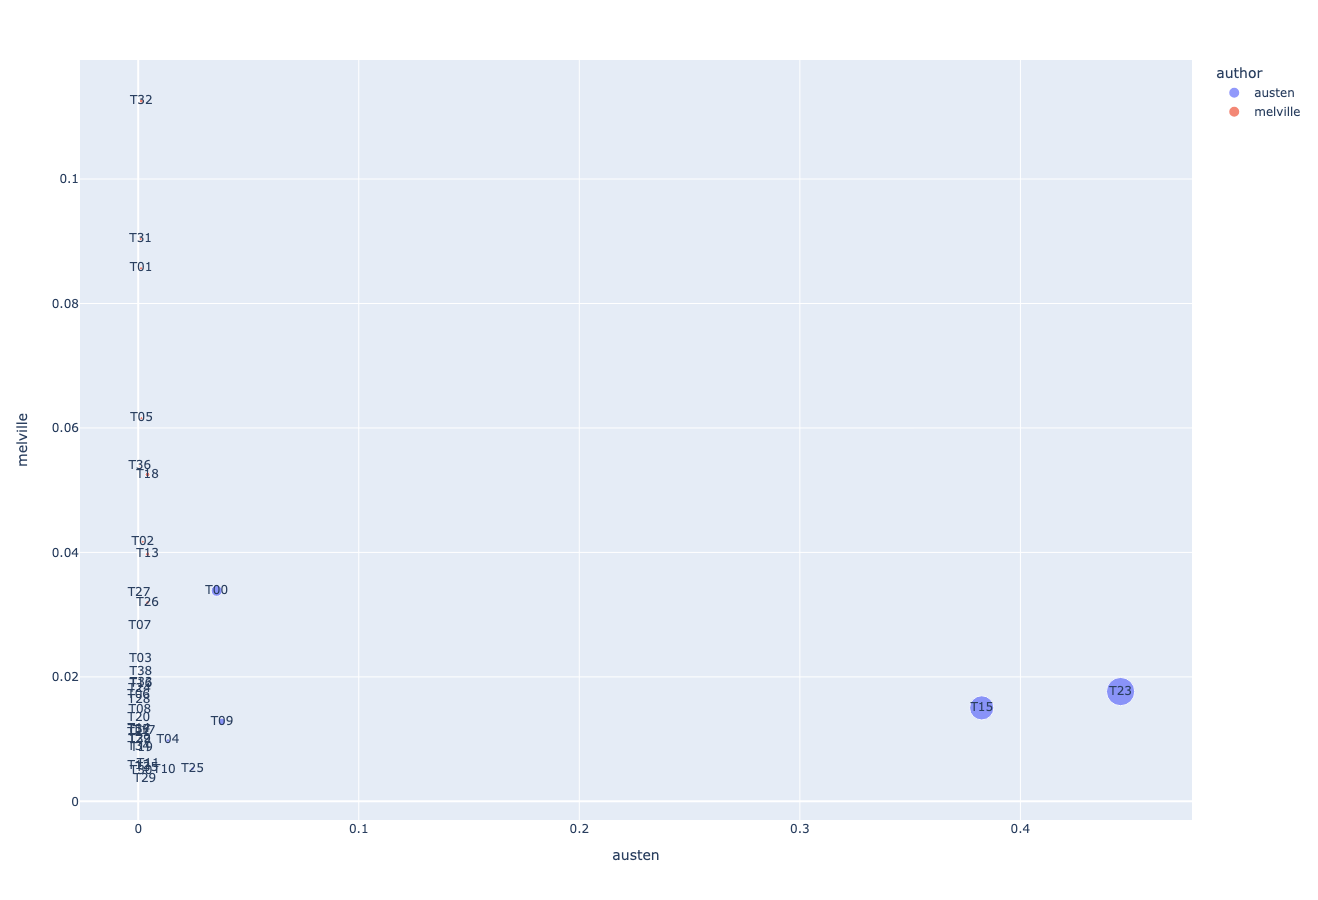

In [131]:
px.scatter(TOPICS.reset_index(), 'austen', 'melville', 
           hover_name='top_terms', text='topic_id', 
           size=(TOPICS.austen * TOPICS.melville),
           color='author',
           width=900, height=900)

Note the scale difference.

# Save Model

In [132]:
DOCS.to_csv(f'{output_dir}/{data_prefix}-LDA_DOCS-chaps.csv')
TOPICS.to_csv(f'{output_dir}/{data_prefix}-LDA_TOPICS-{n_topics}.csv')
THETA.to_csv(f'{output_dir}/{data_prefix}-LDA_THETA-{n_topics}.csv')
PHI.to_csv(f'{output_dir}/{data_prefix}-LDA_PHI-{n_topics}.csv')

We also save the model engine binaries for future use.

In [129]:
import pickle

In [130]:
pickle.dump(lda_model, open(f'{output_dir}/{data_prefix}-lda_model.pickle', 'wb'))
pickle.dump(lda_engine, open(f'{output_dir}/{data_prefix}-lda_engine.pickle', 'wb'))
pickle.dump(count_engine, open(f'{output_dir}/{data_prefix}-count_engine.pickle', 'wb'))
pickle.dump(count_model, open(f'{output_dir}/{data_prefix}-count_model.pickle', 'wb'))